In [38]:
import sklearn

In [39]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [41]:
# Load Dataset
dftrain = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
dfeval = pd.read_csv("https://storage.googleapis.com/tf-datasets/titanic/train.csv")
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

In [42]:
dftrain.head() 
# y_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [43]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [44]:
dftrain.shape

(627, 9)

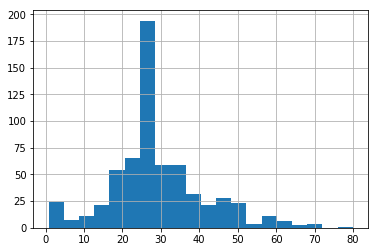

In [45]:
dftrain.age.hist(bins=20)

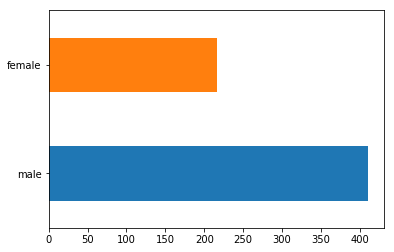

In [46]:
dftrain.sex.value_counts().plot(kind='barh')

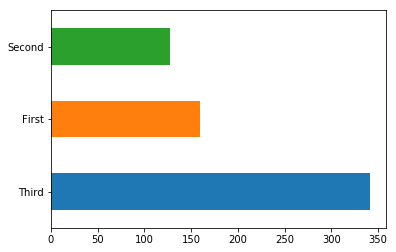

In [47]:
dftrain['class'].value_counts().plot(kind='barh')

Text(0.5, 0, '% survived')

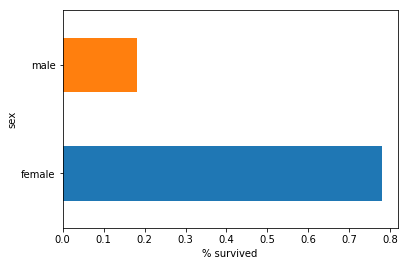

In [48]:
pd.concat([dftrain,y_train],axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survived')

## Training and Testing Datasets

In [49]:
dftrain['sex'].unique()

array(['male', 'female'], dtype=object)

In [50]:
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town','alone']
NUMERIC_COLUMNS = ['age','fare']

feature_columns = [ ]

for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(fc.categorical_column_with_vocabulary_list(feature_name,vocabulary))
    
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(fc.numeric_column(feature_name,dtype = tf.float32))

print(feature_columns)
    

[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0), VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, def

## Create Model

In [54]:
def make_input_fn(data_df,label_df,num_epochs=10,shuffle=True,batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df),label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function


train_input_fn = make_input_fn(dftrain,y_train)
eval_input_fn = make_input_fn(dfeval,y_eval,num_epochs=1,shuffle=False)

In [56]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()

In [57]:
print(result['accuracy'])

0.8118022


In [58]:
print(result)

{'accuracy': 0.8118022, 'accuracy_baseline': 0.61244017, 'auc': 0.8617809, 'auc_precision_recall': 0.81499666, 'average_loss': 0.44961008, 'label/mean': 0.3875598, 'loss': 0.44734842, 'precision': 0.7593361, 'prediction/mean': 0.399541, 'recall': 0.75308645, 'global_step': 200}


In [59]:
result = list(linear_est.predict(eval_input_fn))
print(result[0])

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\AKHILV~1\AppData\Local\Temp\tmpk_q72vij\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-2.2924933], dtype=float32), 'logistic': array([0.09174654], dtype=float32), 'probabilities': array([0.90825343, 0.09174657], dtype=float32), 'class_ids': array([0], dtype=int64), 'classes': 

In [63]:
print(dfeval.loc[7])
print(y_eval.loc[7])
print(result[7]['probabilities'])

sex                      female
age                          14
n_siblings_spouses            1
parch                         0
fare                    30.0708
class                    Second
deck                    unknown
embark_town           Cherbourg
alone                         n
Name: 7, dtype: object
1
[0.07262695 0.9273731 ]
